In [375]:
import numpy as np
import torch
import torch.nn as nn
import random
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [333]:
import torch.nn.functional as F

In [257]:
from torch.optim.lr_scheduler import CyclicLR

In [25]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# Раздел 1: Подготовка данных и работа с несколькими датасетами

## Загрузка и трансформация

In [16]:
transform_cifar_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_fmnist_aug = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

transform_svhn_aug = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_fmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [18]:
cifar10_train = datasets.CIFAR10(root='data', train=True, download = True,transform = transform_cifar)
fmnist_train = datasets.FashionMNIST(root='data', train=True, download = True,transform = transform_fmnist)
svhn_train = datasets.SVHN(root='data', split='train', download = True, transform = transform_svhn)
cifar10_test = datasets.CIFAR10(root='data', train=False, download = True, transform = transform_cifar)
fmnist_test = datasets.FashionMNIST(root='data', train=False,download = True, transform = transform_fmnist)
svhn_test = datasets.SVHN(root='data', split='test', download = True, transform = transform_svhn)

Files already downloaded and verified
Using downloaded and verified file: data\train_32x32.mat
Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


In [44]:
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_train, batch_size=128,
                                          shuffle=True, num_workers=2)
fmnist_trainloader = torch.utils.data.DataLoader(fmnist_train, batch_size=128,
                                          shuffle=True, num_workers=2)
svhn_trainloader = torch.utils.data.DataLoader(svhn_train, batch_size=128,
                                          shuffle=True, num_workers=2)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_test, batch_size=128,
                                          shuffle=True, num_workers=2)
fmnist_testloader = torch.utils.data.DataLoader(fmnist_test, batch_size=128,
                                          shuffle=True, num_workers=2)
svhn_testloader = torch.utils.data.DataLoader(svhn_test, batch_size=128,
                                          shuffle=True, num_workers=2)

In [126]:
cifar10_train_aug = datasets.CIFAR10(root='data', train=True,download = True, transform=transform_cifar_aug)
fmnist_train_aug = datasets.FashionMNIST(root='data', train=True, download = True,transform=transform_fmnist_aug)
svhn_train_aug = datasets.SVHN(root='data', split='train', download = True,transform=transform_svhn_aug)

Files already downloaded and verified
Using downloaded and verified file: data\train_32x32.mat
Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


In [128]:
cifar10_trainloader_aug = torch.utils.data.DataLoader(cifar10_train_aug, batch_size=8,
                                          shuffle=True, num_workers=2)
fmnist_trainloader_aug = torch.utils.data.DataLoader(fmnist_train_aug, batch_size=8,
                                          shuffle=True, num_workers=2)
svhn_trainloader_aug = torch.utils.data.DataLoader(svhn_train_aug, batch_size=8,
                                          shuffle=True, num_workers=2)

## Baseline Модель и функция обучения

In [75]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [79]:
class FmnistCNN(nn.Module):
    def __init__(self):
        super(FmnistCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Размерность изменилась, так как входной размер FMNIST - 28x28
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [26]:
def train_model(model, train_loader, device, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        for batch_features, batch_target in train_loader:
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device).long()
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += batch_target.size(0)
            correct_predictions += (predicted == batch_target).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_samples
        epoch_losses.append(epoch_loss)
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}, Точность: {epoch_accuracy:.4f}')
    print('Обучение завершено.')
    return epoch_losses

In [28]:
def predict_model(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch_features, batch_target in test_loader:
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device).long()

            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total_samples += batch_target.size(0)
            correct_predictions += (predicted == batch_target).sum().item()

            all_labels.extend(batch_target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0

    return all_labels, all_predictions, accuracy

In [220]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Смещение текста по вертикали
                    textcoords="offset points",
                    ha='center', va='bottom')

# Раздел 2. Сравнение предобработки для разных типов данных

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


In [81]:
model_cifar10 = SimpleCNN()
model_cifar10.to(device)
model_fmnist = FmnistCNN()
model_fmnist.to(device)
model_svhn = SimpleCNN()
model_svhn.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [152]:
model_cifar10_aug = SimpleCNN()
model_cifar10_aug.to(device)
model_fmnist_aug = FmnistCNN()
model_fmnist_aug.to(device)
model_svhn_aug = SimpleCNN()
model_svhn_aug.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [96]:
num_epochs = 20
lr = 0.001

### CIFAR10

In [83]:
cifar10_epoch_losses = train_model(model_cifar10, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.3960, Точность: 0.4991
Эпоха [2/20], Потери: 1.0469, Точность: 0.6312
Эпоха [3/20], Потери: 0.9046, Точность: 0.6838
Эпоха [4/20], Потери: 0.8046, Точность: 0.7166
Эпоха [5/20], Потери: 0.7321, Точность: 0.7423
Эпоха [6/20], Потери: 0.6631, Точность: 0.7650
Эпоха [7/20], Потери: 0.6074, Точность: 0.7826
Эпоха [8/20], Потери: 0.5529, Точность: 0.8022
Эпоха [9/20], Потери: 0.5133, Точность: 0.8147
Эпоха [10/20], Потери: 0.4847, Точность: 0.8237
Эпоха [11/20], Потери: 0.4459, Точность: 0.8395
Эпоха [12/20], Потери: 0.4152, Точность: 0.8485
Эпоха [13/20], Потери: 0.3952, Точность: 0.8552
Эпоха [14/20], Потери: 0.3770, Точность: 0.8609
Эпоха [15/20], Потери: 0.3521, Точность: 0.8710
Эпоха [16/20], Потери: 0.3279, Точность: 0.8793
Эпоха [17/20], Потери: 0.3250, Точность: 0.8816
Эпоха [18/20], Потери: 0.3024, Точность: 0.8891
Эпоха [19/20], Потери: 0.2991, Точность: 0.8923
Эпоха [20/20], Потери: 0.2840, Точность: 0.8961
Обучение завершено.


In [89]:
accuracy_0 = predict_model(model_cifar10, cifar10_testloader, device)[2]
accuracy_0

0.7449

In [85]:
cifar10_aug_epoch_losses = train_model(model_cifar10_aug, cifar10_trainloader_aug, device, lr, num_epochs)

NameError: name 'model_cifar10_aug' is not defined

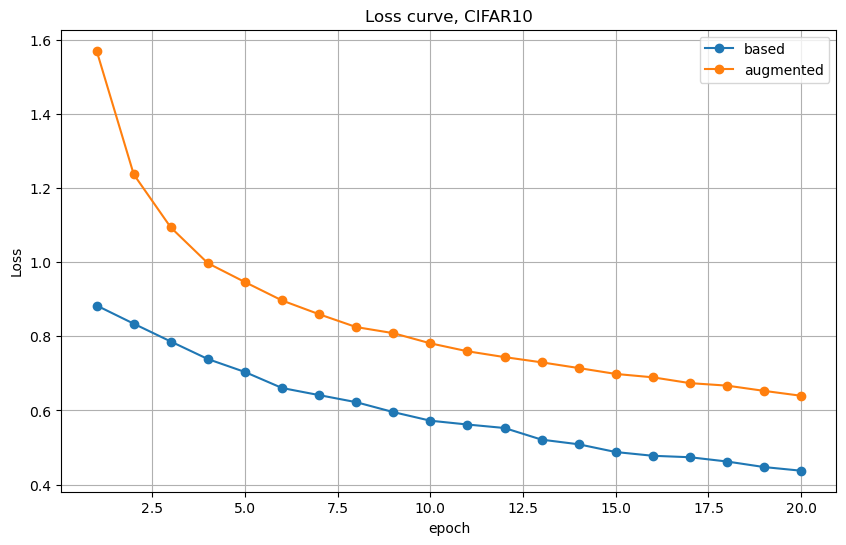

In [170]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), cifar10_epoch_losses, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), cifar10_aug_epoch_losses, marker='o')
plt.title('Loss curve, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2], labels = ['based', 'augmented'])
plt.grid(True)
plt.show()

In [194]:
print(f'accuracy на исходном датасете: {predict_model(model_cifar10, cifar10_testloader, device)[2]}')
print(f'accuracy на аугментированном датасете: {predict_model(model_cifar10_aug, cifar10_testloader, device)[2]}')

accuracy на исходном датасете: 0.1054
accuracy на аугментированном датасете: 0.0986


**Вывод:**   

На данном датасете аугментация в виде горизонтального зеркального отражения не показала сильного влияния на инференсе ни в лучшую, ни в худшую сторону.

### FMNIST

In [154]:
fmnist_epoch_losses = train_model(model_fmnist, fmnist_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 0.4899, Точность: 0.8240
Эпоха [2/20], Потери: 0.3534, Точность: 0.8751
Эпоха [3/20], Потери: 0.3024, Точность: 0.8913
Эпоха [4/20], Потери: 0.2756, Точность: 0.9014
Эпоха [5/20], Потери: 0.2528, Точность: 0.9094
Эпоха [6/20], Потери: 0.2351, Точность: 0.9143
Эпоха [7/20], Потери: 0.2208, Точность: 0.9194
Эпоха [8/20], Потери: 0.2058, Точность: 0.9256
Эпоха [9/20], Потери: 0.2006, Точность: 0.9272
Эпоха [10/20], Потери: 0.1964, Точность: 0.9284
Эпоха [11/20], Потери: 0.1837, Точность: 0.9313
Эпоха [12/20], Потери: 0.1790, Точность: 0.9352
Эпоха [13/20], Потери: 0.1732, Точность: 0.9361
Эпоха [14/20], Потери: 0.1665, Точность: 0.9391
Эпоха [15/20], Потери: 0.1635, Точность: 0.9394
Эпоха [16/20], Потери: 0.1566, Точность: 0.9424
Эпоха [17/20], Потери: 0.1568, Точность: 0.9430
Эпоха [18/20], Потери: 0.1504, Точность: 0.9444
Эпоха [19/20], Потери: 0.1448, Точность: 0.9459
Эпоха [20/20], Потери: 0.1443, Точность: 0.9460
Обучение завершено.


In [156]:
fmnist_aug_epoch_losses = train_model(model_fmnist_aug, fmnist_trainloader_aug, device, lr, num_epochs)

Эпоха [1/20], Потери: 0.5539, Точность: 0.8008
Эпоха [2/20], Потери: 0.4043, Точность: 0.8569
Эпоха [3/20], Потери: 0.3585, Точность: 0.8708
Эпоха [4/20], Потери: 0.3296, Точность: 0.8825
Эпоха [5/20], Потери: 0.3093, Точность: 0.8880
Эпоха [6/20], Потери: 0.2964, Точность: 0.8937
Эпоха [7/20], Потери: 0.2901, Точность: 0.8962
Эпоха [8/20], Потери: 0.2765, Точность: 0.8989
Эпоха [9/20], Потери: 0.2758, Точность: 0.9012
Эпоха [10/20], Потери: 0.2649, Точность: 0.9034
Эпоха [11/20], Потери: 0.2651, Точность: 0.9047
Эпоха [12/20], Потери: 0.2609, Точность: 0.9069
Эпоха [13/20], Потери: 0.2573, Точность: 0.9085
Эпоха [14/20], Потери: 0.2526, Точность: 0.9080
Эпоха [15/20], Потери: 0.2440, Точность: 0.9111
Эпоха [16/20], Потери: 0.2478, Точность: 0.9103
Эпоха [17/20], Потери: 0.2439, Точность: 0.9134
Эпоха [18/20], Потери: 0.2422, Точность: 0.9127
Эпоха [19/20], Потери: 0.2391, Точность: 0.9130
Эпоха [20/20], Потери: 0.2366, Точность: 0.9138
Обучение завершено.


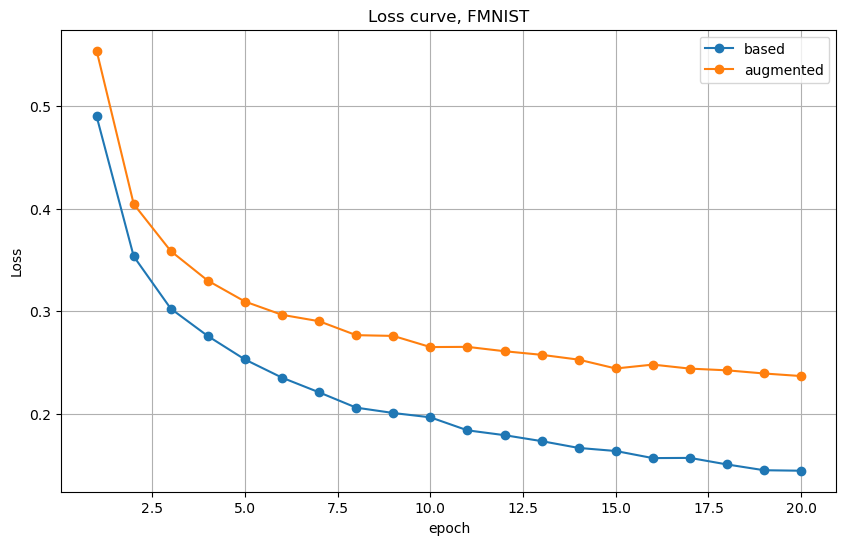

In [202]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), fmnist_epoch_losses, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), fmnist_aug_epoch_losses, marker='o')
plt.title('Loss curve, FMNIST')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2], labels = ['based', 'augmented'])
plt.grid(True)
plt.show()

In [196]:
print(f'accuracy на исходном датасете: {predict_model(model_fmnist, fmnist_testloader, device)[2]}')
print(f'accuracy на аугментированном датасете: {predict_model(model_fmnist_aug, fmnist_testloader, device)[2]}')

accuracy на исходном датасете: 0.9176
accuracy на аугментированном датасете: 0.9159


В данном случае также, несмотря на ухудшение сходимости лосса при обучении, на тесте результаты немного хуже, но некритично

### SVHN

In [157]:
svhn_epoch_losses = train_model(model_svhn, svhn_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 0.8462, Точность: 0.7288
Эпоха [2/20], Потери: 0.5501, Точность: 0.8317
Эпоха [3/20], Потери: 0.4718, Точность: 0.8555
Эпоха [4/20], Потери: 0.4315, Точность: 0.8698
Эпоха [5/20], Потери: 0.4003, Точность: 0.8776
Эпоха [6/20], Потери: 0.3787, Точность: 0.8851
Эпоха [7/20], Потери: 0.3600, Точность: 0.8908
Эпоха [8/20], Потери: 0.3525, Точность: 0.8938
Эпоха [9/20], Потери: 0.3347, Точность: 0.8971
Эпоха [10/20], Потери: 0.3263, Точность: 0.9006
Эпоха [11/20], Потери: 0.3145, Точность: 0.9030
Эпоха [12/20], Потери: 0.3059, Точность: 0.9065
Эпоха [13/20], Потери: 0.3000, Точность: 0.9070
Эпоха [14/20], Потери: 0.2914, Точность: 0.9099
Эпоха [15/20], Потери: 0.2843, Точность: 0.9127
Эпоха [16/20], Потери: 0.2783, Точность: 0.9137
Эпоха [17/20], Потери: 0.2745, Точность: 0.9146
Эпоха [18/20], Потери: 0.2700, Точность: 0.9159
Эпоха [19/20], Потери: 0.2649, Точность: 0.9176
Эпоха [20/20], Потери: 0.2602, Точность: 0.9187
Обучение завершено.


In [158]:
svhn_aug_epoch_losses = train_model(model_svhn_aug, svhn_trainloader_aug, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.3889, Точность: 0.5185
Эпоха [2/20], Потери: 0.8699, Точность: 0.7197
Эпоха [3/20], Потери: 0.7452, Точность: 0.7624
Эпоха [4/20], Потери: 0.6771, Точность: 0.7850
Эпоха [5/20], Потери: 0.6410, Точность: 0.7980
Эпоха [6/20], Потери: 0.6097, Точность: 0.8076
Эпоха [7/20], Потери: 0.5869, Точность: 0.8145
Эпоха [8/20], Потери: 0.5757, Точность: 0.8206
Эпоха [9/20], Потери: 0.5572, Точность: 0.8264
Эпоха [10/20], Потери: 0.5409, Точность: 0.8299
Эпоха [11/20], Потери: 0.5371, Точность: 0.8323
Эпоха [12/20], Потери: 0.5190, Точность: 0.8388
Эпоха [13/20], Потери: 0.5137, Точность: 0.8393
Эпоха [14/20], Потери: 0.5074, Точность: 0.8414
Эпоха [15/20], Потери: 0.5024, Точность: 0.8436
Эпоха [16/20], Потери: 0.4950, Точность: 0.8441
Эпоха [17/20], Потери: 0.4924, Точность: 0.8460
Эпоха [18/20], Потери: 0.4824, Точность: 0.8484
Эпоха [19/20], Потери: 0.4822, Точность: 0.8486
Эпоха [20/20], Потери: 0.4764, Точность: 0.8517
Обучение завершено.


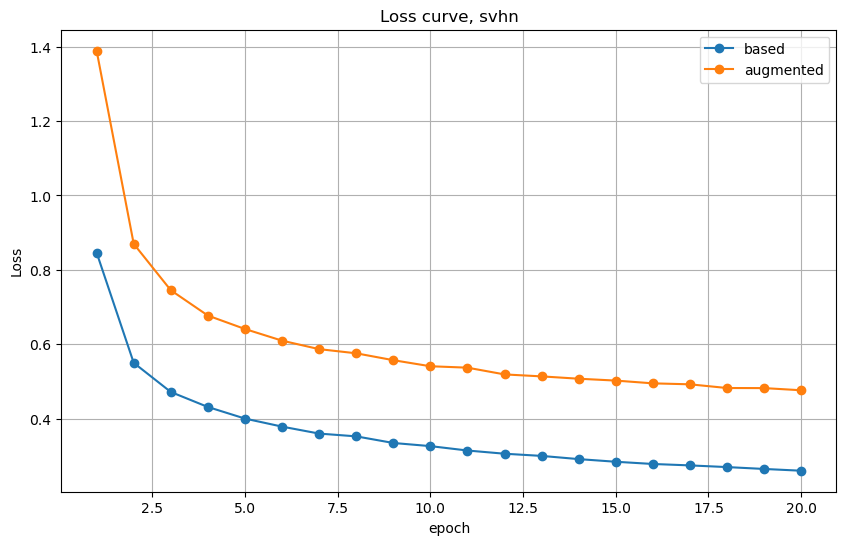

In [199]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), svhn_epoch_losses, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), svhn_aug_epoch_losses, marker='o')
plt.title('Loss curve, svhn')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2], labels = ['based', 'augmented'])
plt.grid(True)
plt.show()

In [198]:
print(f'accuracy на исходном датасете: {predict_model(model_svhn, svhn_testloader, device)[2]}')
print(f'accuracy на аугментированном датасете: {predict_model(model_svhn_aug, svhn_testloader, device)[2]}')

accuracy на исходном датасете: 0.8950522433927474
accuracy на аугментированном датасете: 0.8474953902888752


На данном примере аугментированный датасет показал себя существенно хуже на инференсе (было уменьшение яркости и отзеркаливание). Это может быть связано с достаточным количеством картинок в исходном наборе данных, либо с выбором неподходящих методов аугментации

# Раздел 3. Создание и оптимизация архитектуры CNN (CIFAR)

Используем Cifar10 в качестве датасета. Трансформации и разбиение на трейн/тест были проделаны выше   
- transform_cifar
- cifar10_train
- cifar10_test
- cifar10_trainloader
- cifar10_testloader

Baseline - **SimpleCNN**

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
num_epochs = 20
lr = 0.001
accuracy_list = []

Используемое устройство: cuda


## 1. Количество и размер сверточных фильтров

### Использование меньшего количества фильтров (16 и 32) с ядрами 3x3 и 5x5

In [22]:
class SimpleCNNVariant1(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant1, self).__init__()
        self.conv1_3x3 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1_5x5 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_3x3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv2_5x5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.batch_norm = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x1 = self.pool(torch.relu(self.conv1_3x3(x)))
        x2 = self.pool(torch.relu(self.conv1_5x5(x)))
        x = torch.cat((x1, x2), dim=1)
        x1 = self.pool(torch.relu(self.conv2_3x3(x)))
        x2 = self.pool(torch.relu(self.conv2_5x5(x)))
        x = torch.cat((x1, x2), dim=1)
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [48]:
model_cifar10_1 = SimpleCNNVariant1()
model_cifar10_1.to(device)
train_1_1 = train_model(model_cifar10_1, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.5798, Точность: 0.4294
Эпоха [2/20], Потери: 1.2176, Точность: 0.5674
Эпоха [3/20], Потери: 1.0695, Точность: 0.6251
Эпоха [4/20], Потери: 0.9792, Точность: 0.6578
Эпоха [5/20], Потери: 0.9123, Точность: 0.6805
Эпоха [6/20], Потери: 0.8587, Точность: 0.6980
Эпоха [7/20], Потери: 0.8070, Точность: 0.7182
Эпоха [8/20], Потери: 0.7648, Точность: 0.7294
Эпоха [9/20], Потери: 0.7254, Точность: 0.7443
Эпоха [10/20], Потери: 0.6935, Точность: 0.7532
Эпоха [11/20], Потери: 0.6541, Точность: 0.7695
Эпоха [12/20], Потери: 0.6246, Точность: 0.7747
Эпоха [13/20], Потери: 0.5963, Точность: 0.7852
Эпоха [14/20], Потери: 0.5727, Точность: 0.7928
Эпоха [15/20], Потери: 0.5464, Точность: 0.8026
Эпоха [16/20], Потери: 0.5276, Точность: 0.8071
Эпоха [17/20], Потери: 0.5046, Точность: 0.8145
Эпоха [18/20], Потери: 0.4860, Точность: 0.8226
Эпоха [19/20], Потери: 0.4653, Точность: 0.8291
Эпоха [20/20], Потери: 0.4506, Точность: 0.8324
Обучение завершено.


In [124]:
accuracy_1_1 = predict_model(model_cifar10_1, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_1)

### Увеличение числа фильтров (64 и 128) для более сложных признаков

In [54]:
class SimpleCNNVariant2(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant2, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [56]:
model_cifar10_2 = SimpleCNNVariant2()
model_cifar10_2.to(device)
train_1_2 = train_model(model_cifar10_2, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.4015, Точность: 0.5048
Эпоха [2/20], Потери: 1.0153, Точность: 0.6423
Эпоха [3/20], Потери: 0.8466, Точность: 0.7043
Эпоха [4/20], Потери: 0.7169, Точность: 0.7479
Эпоха [5/20], Потери: 0.6286, Точность: 0.7787
Эпоха [6/20], Потери: 0.5449, Точность: 0.8090
Эпоха [7/20], Потери: 0.4748, Точность: 0.8339
Эпоха [8/20], Потери: 0.4022, Точность: 0.8594
Эпоха [9/20], Потери: 0.3549, Точность: 0.8739
Эпоха [10/20], Потери: 0.3226, Точность: 0.8849
Эпоха [11/20], Потери: 0.2902, Точность: 0.8967
Эпоха [12/20], Потери: 0.2630, Точность: 0.9080
Эпоха [13/20], Потери: 0.2479, Точность: 0.9130
Эпоха [14/20], Потери: 0.2327, Точность: 0.9177
Эпоха [15/20], Потери: 0.2216, Точность: 0.9217
Эпоха [16/20], Потери: 0.2095, Точность: 0.9270
Эпоха [17/20], Потери: 0.1924, Точность: 0.9317
Эпоха [18/20], Потери: 0.1904, Точность: 0.9323
Эпоха [19/20], Потери: 0.1900, Точность: 0.9346
Эпоха [20/20], Потери: 0.1714, Точность: 0.9393
Обучение завершено.


In [125]:
accuracy_1_2 = predict_model(model_cifar10_2, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_2)

### Слой с фильтром 7x7 и 256 каналами

In [65]:
class SimpleCNNVariant3(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant3, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=7, padding=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.batch_norm = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 256 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [66]:
model_cifar10_3 = SimpleCNNVariant3()
model_cifar10_3.to(device)
train_1_3 = train_model(model_cifar10_3, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.6160, Точность: 0.4358
Эпоха [2/20], Потери: 1.1695, Точность: 0.5863
Эпоха [3/20], Потери: 0.9769, Точность: 0.6593
Эпоха [4/20], Потери: 0.8218, Точность: 0.7138
Эпоха [5/20], Потери: 0.7083, Точность: 0.7525
Эпоха [6/20], Потери: 0.6063, Точность: 0.7888
Эпоха [7/20], Потери: 0.5015, Точность: 0.8254
Эпоха [8/20], Потери: 0.4250, Точность: 0.8515
Эпоха [9/20], Потери: 0.3699, Точность: 0.8698
Эпоха [10/20], Потери: 0.3219, Точность: 0.8881
Эпоха [11/20], Потери: 0.2835, Точность: 0.9016
Эпоха [12/20], Потери: 0.2486, Точность: 0.9155
Эпоха [13/20], Потери: 0.2254, Точность: 0.9233
Эпоха [14/20], Потери: 0.2124, Точность: 0.9278
Эпоха [15/20], Потери: 0.1977, Точность: 0.9327
Эпоха [16/20], Потери: 0.1904, Точность: 0.9352
Эпоха [17/20], Потери: 0.1830, Точность: 0.9392
Эпоха [18/20], Потери: 0.1754, Точность: 0.9419
Эпоха [19/20], Потери: 0.1636, Точность: 0.9445
Эпоха [20/20], Потери: 0.1555, Точность: 0.9481
Обучение завершено.


In [127]:
accuracy_1_3 = predict_model(model_cifar10_3, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_3)

### Определение правильного направления оптимизации

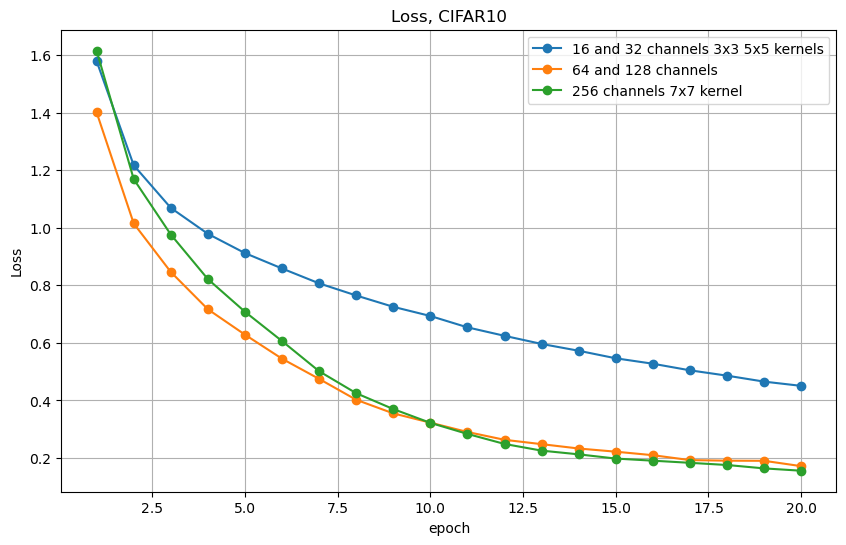

In [194]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), train_1_1, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), train_1_2, marker='o')
l3, = plt.plot(range(1, num_epochs + 1), train_1_3, marker='o')
plt.title('Loss, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2, l3], labels = ['16 and 32 channels 3x3 5x5 kernels', '64 and 128 channels', '256 channels 7x7 kernel'])
plt.grid(True)
plt.show()

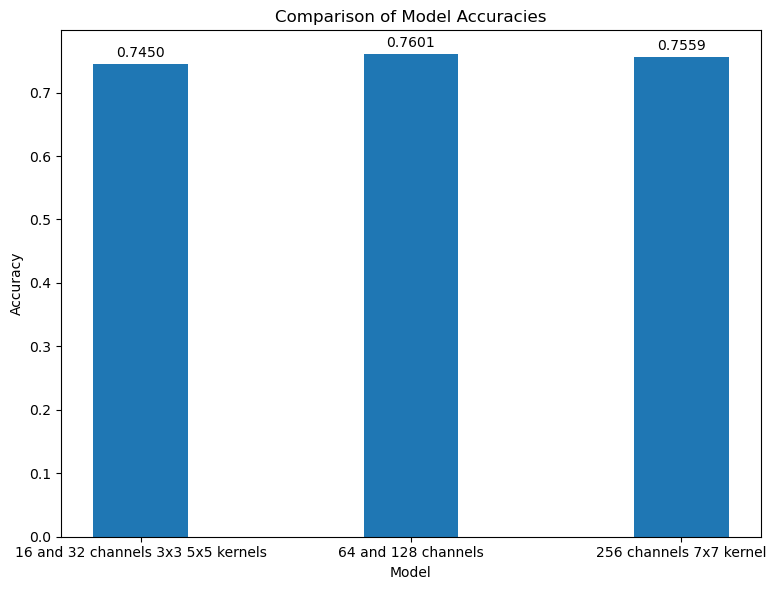

In [229]:
model_names = ['16 and 32 channels 3x3 5x5 kernels', '64 and 128 channels', '256 channels 7x7 kernel']
x = np.arange(len(model_names))
data = accuracy_list[:3]
width = 0.35
fig, ax = plt.subplots(figsize = (8, 6))
rects1 = ax.bar(x, data, width, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Comparison of Model Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
autolabel(rects1)
fig.tight_layout()
plt.show()

Увеличение числа каналов хорошо сказалось на качестве обучения модели и на метриках на тесте.  
При этом, увеличение каналов до 256 и увеличение ядра до 7х7 оказалось излишним, так как не принесло существенных результатов ни на обучении, ни на инференсе

## 2. Пулинг (Pooling) слои

### Max Pooling с размером 2x2, stride 2

In [99]:
class SimpleCNNVariant4(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [101]:
model_cifar10_4 = SimpleCNNVariant4()
model_cifar10_4.to(device)
train_1_4 = train_model(model_cifar10_4, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.4103, Точность: 0.4946
Эпоха [2/20], Потери: 1.0491, Точность: 0.6273
Эпоха [3/20], Потери: 0.8996, Точность: 0.6853
Эпоха [4/20], Потери: 0.7937, Точность: 0.7238
Эпоха [5/20], Потери: 0.7251, Точность: 0.7464
Эпоха [6/20], Потери: 0.6558, Точность: 0.7678
Эпоха [7/20], Потери: 0.5962, Точность: 0.7872
Эпоха [8/20], Потери: 0.5508, Точность: 0.8044
Эпоха [9/20], Потери: 0.4994, Точность: 0.8230
Эпоха [10/20], Потери: 0.4635, Точность: 0.8345
Эпоха [11/20], Потери: 0.4379, Точность: 0.8418
Эпоха [12/20], Потери: 0.4047, Точность: 0.8550
Эпоха [13/20], Потери: 0.3822, Точность: 0.8619
Эпоха [14/20], Потери: 0.3601, Точность: 0.8693
Эпоха [15/20], Потери: 0.3429, Точность: 0.8769
Эпоха [16/20], Потери: 0.3309, Точность: 0.8794
Эпоха [17/20], Потери: 0.3171, Точность: 0.8844
Эпоха [18/20], Потери: 0.3027, Точность: 0.8909
Эпоха [19/20], Потери: 0.2882, Точность: 0.8946
Эпоха [20/20], Потери: 0.2771, Точность: 0.9004
Обучение завершено.


In [129]:
accuracy_1_4 = predict_model(model_cifar10_4, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_4)

### Max Pooling с большим размером ядра (3x3) для более сильного снижения размерности

In [107]:
class SimpleCNNVariant5(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 3 * 3)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [109]:
model_cifar10_5 = SimpleCNNVariant5()
model_cifar10_5.to(device)
train_1_5 = train_model(model_cifar10_5, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.4979, Точность: 0.4571
Эпоха [2/20], Потери: 1.1414, Точность: 0.5953
Эпоха [3/20], Потери: 1.0110, Точность: 0.6457
Эпоха [4/20], Потери: 0.9317, Точность: 0.6736
Эпоха [5/20], Потери: 0.8734, Точность: 0.6949
Эпоха [6/20], Потери: 0.8316, Точность: 0.7108
Эпоха [7/20], Потери: 0.7854, Точность: 0.7248
Эпоха [8/20], Потери: 0.7585, Точность: 0.7351
Эпоха [9/20], Потери: 0.7356, Точность: 0.7414
Эпоха [10/20], Потери: 0.7129, Точность: 0.7493
Эпоха [11/20], Потери: 0.6843, Точность: 0.7605
Эпоха [12/20], Потери: 0.6665, Точность: 0.7653
Эпоха [13/20], Потери: 0.6532, Точность: 0.7709
Эпоха [14/20], Потери: 0.6380, Точность: 0.7753
Эпоха [15/20], Потери: 0.6161, Точность: 0.7829
Эпоха [16/20], Потери: 0.6071, Точность: 0.7849
Эпоха [17/20], Потери: 0.5963, Точность: 0.7868
Эпоха [18/20], Потери: 0.5814, Точность: 0.7918
Эпоха [19/20], Потери: 0.5766, Точность: 0.7941
Эпоха [20/20], Потери: 0.5571, Точность: 0.8001
Обучение завершено.


In [130]:
accuracy_1_5 = predict_model(model_cifar10_5, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_5)

### Average Pooling для сглаживания признаков

In [110]:
class SimpleCNNVariant6(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant6, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [111]:
model_cifar10_6 = SimpleCNNVariant6()
model_cifar10_6.to(device)
train_1_6 = train_model(model_cifar10_6, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.3478, Точность: 0.5182
Эпоха [2/20], Потери: 0.9907, Точность: 0.6514
Эпоха [3/20], Потери: 0.8419, Точность: 0.7039
Эпоха [4/20], Потери: 0.7478, Точность: 0.7356
Эпоха [5/20], Потери: 0.6732, Точность: 0.7625
Эпоха [6/20], Потери: 0.6035, Точность: 0.7856
Эпоха [7/20], Потери: 0.5464, Точность: 0.8050
Эпоха [8/20], Потери: 0.4996, Точность: 0.8227
Эпоха [9/20], Потери: 0.4528, Точность: 0.8385
Эпоха [10/20], Потери: 0.4260, Точность: 0.8463
Эпоха [11/20], Потери: 0.3933, Точность: 0.8582
Эпоха [12/20], Потери: 0.3669, Точность: 0.8658
Эпоха [13/20], Потери: 0.3397, Точность: 0.8771
Эпоха [14/20], Потери: 0.3174, Точность: 0.8844
Эпоха [15/20], Потери: 0.3026, Точность: 0.8906
Эпоха [16/20], Потери: 0.2878, Точность: 0.8943
Эпоха [17/20], Потери: 0.2758, Точность: 0.8984
Эпоха [18/20], Потери: 0.2616, Точность: 0.9043
Эпоха [19/20], Потери: 0.2513, Точность: 0.9070
Эпоха [20/20], Потери: 0.2404, Точность: 0.9114
Обучение завершено.


In [132]:
accuracy_1_6 = predict_model(model_cifar10_6, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_6)

### Определение правильного направления оптимизации

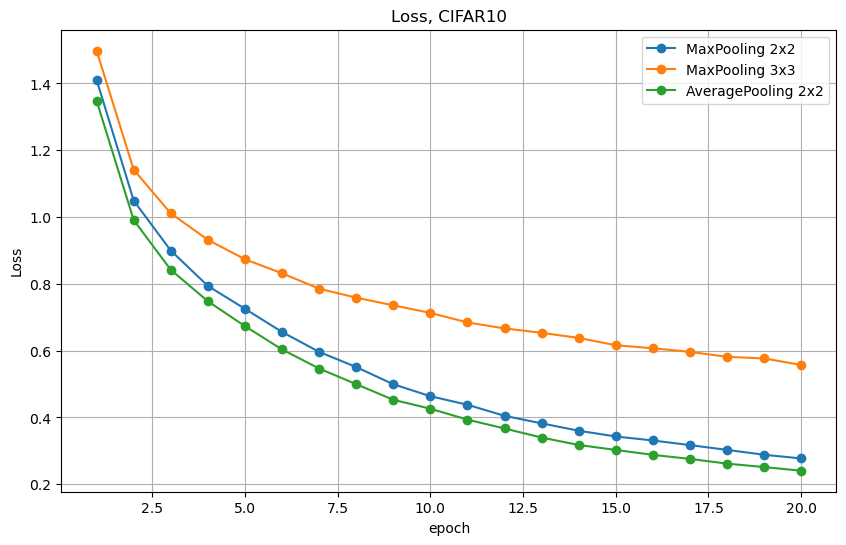

In [225]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), train_1_4, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), train_1_5, marker='o')
l3, = plt.plot(range(1, num_epochs + 1), train_1_6, marker='o')
plt.title('Loss, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2, l3], labels = ['MaxPooling 2x2', 'MaxPooling 3x3', 'AveragePooling 2x2'])
plt.grid(True)
plt.show()

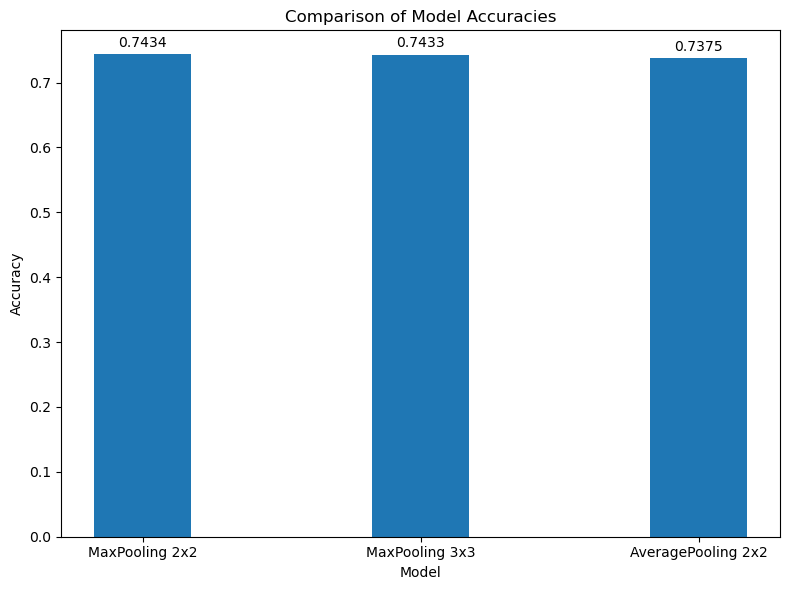

In [231]:
model_names = ['MaxPooling 2x2', 'MaxPooling 3x3', 'AveragePooling 2x2']
x = np.arange(len(model_names))
data = accuracy_list[3:6]
width = 0.35
fig, ax = plt.subplots(figsize = (8, 6))
rects1 = ax.bar(x, data, width, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Comparison of Model Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
autolabel(rects1)
fig.tight_layout()
plt.show()

На этапе обучения пулинг 3х3 ухудшает сходимость лосса, Max и Average показывают схожие результаты. 
В то же время, на инференсе accuracy практически одинакова для моделей с  макс пулингом 2х2 и 3х3, для average пулинга результаты несколько хуже

## 3. Batch Normalization

### Batch Normalization после каждого сверточного слоя

In [141]:
class SimpleCNNVariant7(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant7, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [143]:
model_cifar10_7 = SimpleCNNVariant7()
model_cifar10_7.to(device)
train_1_7 = train_model(model_cifar10_7, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.6350, Точность: 0.3911
Эпоха [2/20], Потери: 1.3546, Точность: 0.5008
Эпоха [3/20], Потери: 1.2598, Точность: 0.5381
Эпоха [4/20], Потери: 1.2002, Точность: 0.5657
Эпоха [5/20], Потери: 1.1459, Точность: 0.5810
Эпоха [6/20], Потери: 1.1181, Точность: 0.5943
Эпоха [7/20], Потери: 1.0807, Точность: 0.6078
Эпоха [8/20], Потери: 1.0529, Точность: 0.6205
Эпоха [9/20], Потери: 1.0278, Точность: 0.6259
Эпоха [10/20], Потери: 0.9962, Точность: 0.6373
Эпоха [11/20], Потери: 0.9682, Точность: 0.6482
Эпоха [12/20], Потери: 0.9538, Точность: 0.6514
Эпоха [13/20], Потери: 0.9236, Точность: 0.6619
Эпоха [14/20], Потери: 0.9119, Точность: 0.6658
Эпоха [15/20], Потери: 0.8917, Точность: 0.6733
Эпоха [16/20], Потери: 0.8801, Точность: 0.6777
Эпоха [17/20], Потери: 0.8542, Точность: 0.6861
Эпоха [18/20], Потери: 0.8334, Точность: 0.6933
Эпоха [19/20], Потери: 0.8220, Точность: 0.6964
Эпоха [20/20], Потери: 0.8080, Точность: 0.7012
Обучение завершено.


In [144]:
accuracy_1_7 = predict_model(model_cifar10_7, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_7)

### Batch Normalization только в начале и конце сети

In [145]:
class SimpleCNNVariant8(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant8, self).__init__()
        self.bn_input = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.bn_input(x)
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(torch.relu(self.conv2(x))))))
        x = x.view(-1, 128 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [149]:
model_cifar10_8 = SimpleCNNVariant8()
model_cifar10_8.to(device)
train_1_8 = train_model(model_cifar10_8, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.8638, Точность: 0.2782
Эпоха [2/20], Потери: 1.6584, Точность: 0.3475
Эпоха [3/20], Потери: 1.5736, Точность: 0.3822
Эпоха [4/20], Потери: 1.5014, Точность: 0.4105
Эпоха [5/20], Потери: 1.4602, Точность: 0.4245
Эпоха [6/20], Потери: 1.4250, Точность: 0.4407
Эпоха [7/20], Потери: 1.3863, Точность: 0.4535
Эпоха [8/20], Потери: 1.3635, Точность: 0.4659
Эпоха [9/20], Потери: 1.3303, Точность: 0.4786
Эпоха [10/20], Потери: 1.3064, Точность: 0.4885
Эпоха [11/20], Потери: 1.2832, Точность: 0.5010
Эпоха [12/20], Потери: 1.2586, Точность: 0.5141
Эпоха [13/20], Потери: 1.2444, Точность: 0.5202
Эпоха [14/20], Потери: 1.2224, Точность: 0.5271
Эпоха [15/20], Потери: 1.2061, Точность: 0.5329
Эпоха [16/20], Потери: 1.1905, Точность: 0.5372
Эпоха [17/20], Потери: 1.1805, Точность: 0.5445
Эпоха [18/20], Потери: 1.1531, Точность: 0.5519
Эпоха [19/20], Потери: 1.1394, Точность: 0.5592
Эпоха [20/20], Потери: 1.1220, Точность: 0.5648
Обучение завершено.


In [150]:
accuracy_1_8 = predict_model(model_cifar10_8, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_8)

### Определение правильного направления оптимизации

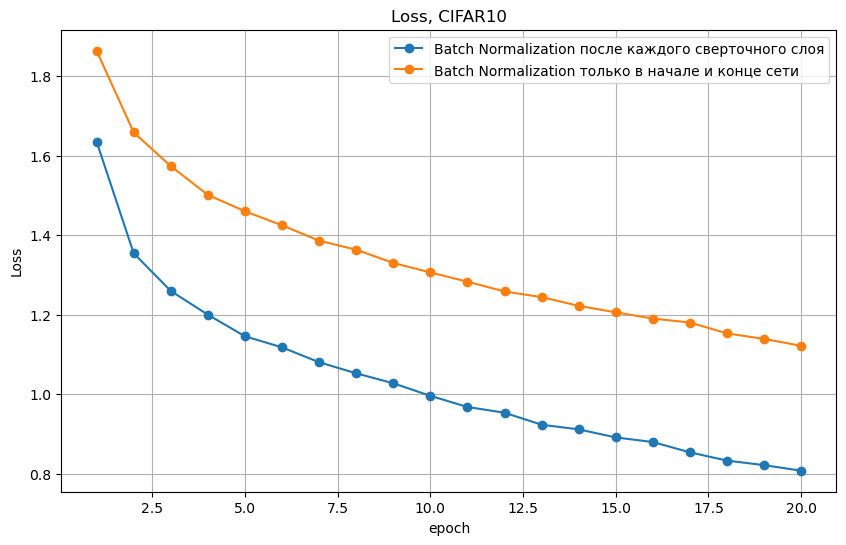

In [234]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), train_1_7, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), train_1_8, marker='o')
plt.title('Loss, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2], labels = ['Batch Normalization после каждого сверточного слоя', 'Batch Normalization только в начале и конце сети'])
plt.grid(True)
plt.show()

In [236]:
accuracy_list[6:8]

[0.7234, 0.7109]

Результаты очевидны - батч нормализация после каждого слоя лучше показывает себя и на этапе обучения, и на инференсе

## 4. Dropout

### Умеренный Dropout (0.2)

In [160]:
class SimpleCNNVariant9(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant9, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [162]:
model_cifar10_9 = SimpleCNNVariant9()
model_cifar10_9.to(device)
train_1_9 = train_model(model_cifar10_9, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.2376, Точность: 0.5586
Эпоха [2/20], Потери: 0.8797, Точность: 0.6900
Эпоха [3/20], Потери: 0.7001, Точность: 0.7532
Эпоха [4/20], Потери: 0.5696, Точность: 0.8001
Эпоха [5/20], Потери: 0.4580, Точность: 0.8379
Эпоха [6/20], Потери: 0.3682, Точность: 0.8697
Эпоха [7/20], Потери: 0.2976, Точность: 0.8943
Эпоха [8/20], Потери: 0.2497, Точность: 0.9135
Эпоха [9/20], Потери: 0.2139, Точность: 0.9251
Эпоха [10/20], Потери: 0.1900, Точность: 0.9335
Эпоха [11/20], Потери: 0.1710, Точность: 0.9398
Эпоха [12/20], Потери: 0.1633, Точность: 0.9430
Эпоха [13/20], Потери: 0.1470, Точность: 0.9486
Эпоха [14/20], Потери: 0.1350, Точность: 0.9527
Эпоха [15/20], Потери: 0.1323, Точность: 0.9542
Эпоха [16/20], Потери: 0.1250, Точность: 0.9568
Эпоха [17/20], Потери: 0.1169, Точность: 0.9588
Эпоха [18/20], Потери: 0.1144, Точность: 0.9603
Эпоха [19/20], Потери: 0.1122, Точность: 0.9612
Эпоха [20/20], Потери: 0.1090, Точность: 0.9630
Обучение завершено.


In [163]:
accuracy_1_9 = predict_model(model_cifar10_9, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_9)

### Сильный Dropout (0.5)

In [164]:
class SimpleCNNVariant10(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant10, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128) 
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [165]:
model_cifar10_10 = SimpleCNNVariant10()
model_cifar10_10.to(device)
train_1_10 = train_model(model_cifar10_10, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.4340, Точность: 0.4837
Эпоха [2/20], Потери: 1.0713, Точность: 0.6195
Эпоха [3/20], Потери: 0.9136, Точность: 0.6775
Эпоха [4/20], Потери: 0.8149, Точность: 0.7125
Эпоха [5/20], Потери: 0.7297, Точность: 0.7402
Эпоха [6/20], Потери: 0.6591, Точность: 0.7658
Эпоха [7/20], Потери: 0.6033, Точность: 0.7832
Эпоха [8/20], Потери: 0.5569, Точность: 0.8011
Эпоха [9/20], Потери: 0.5121, Точность: 0.8140
Эпоха [10/20], Потери: 0.4681, Точность: 0.8315
Эпоха [11/20], Потери: 0.4434, Точность: 0.8404
Эпоха [12/20], Потери: 0.4167, Точность: 0.8471
Эпоха [13/20], Потери: 0.3933, Точность: 0.8581
Эпоха [14/20], Потери: 0.3683, Точность: 0.8644
Эпоха [15/20], Потери: 0.3490, Точность: 0.8730
Эпоха [16/20], Потери: 0.3321, Точность: 0.8771
Эпоха [17/20], Потери: 0.3236, Точность: 0.8812
Эпоха [18/20], Потери: 0.3109, Точность: 0.8875
Эпоха [19/20], Потери: 0.2943, Точность: 0.8912
Эпоха [20/20], Потери: 0.2888, Точность: 0.8947
Обучение завершено.


In [166]:
accuracy_1_10 = predict_model(model_cifar10_10, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_10)

### Комбинация разных значений Dropout в одном слое

In [167]:
class SimpleCNNVariant11(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant11, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [168]:
model_cifar10_11 = SimpleCNNVariant11()
model_cifar10_11.to(device)
train_1_11 = train_model(model_cifar10_11, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.5725, Точность: 0.4367
Эпоха [2/20], Потери: 1.2234, Точность: 0.5673
Эпоха [3/20], Потери: 1.0797, Точность: 0.6177
Эпоха [4/20], Потери: 0.9922, Точность: 0.6523
Эпоха [5/20], Потери: 0.9110, Точность: 0.6787
Эпоха [6/20], Потери: 0.8617, Точность: 0.6986
Эпоха [7/20], Потери: 0.8205, Точность: 0.7114
Эпоха [8/20], Потери: 0.7815, Точность: 0.7251
Эпоха [9/20], Потери: 0.7383, Точность: 0.7371
Эпоха [10/20], Потери: 0.7064, Точность: 0.7500
Эпоха [11/20], Потери: 0.6749, Точность: 0.7589
Эпоха [12/20], Потери: 0.6453, Точность: 0.7712
Эпоха [13/20], Потери: 0.6205, Точность: 0.7772
Эпоха [14/20], Потери: 0.5929, Точность: 0.7868
Эпоха [15/20], Потери: 0.5783, Точность: 0.7931
Эпоха [16/20], Потери: 0.5559, Точность: 0.7995
Эпоха [17/20], Потери: 0.5372, Точность: 0.8044
Эпоха [18/20], Потери: 0.5220, Точность: 0.8091
Эпоха [19/20], Потери: 0.5032, Точность: 0.8181
Эпоха [20/20], Потери: 0.4896, Точность: 0.8230
Обучение завершено.


In [169]:
accuracy_1_11 = predict_model(model_cifar10_11, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_11)

### Определение правильного направления оптимизации

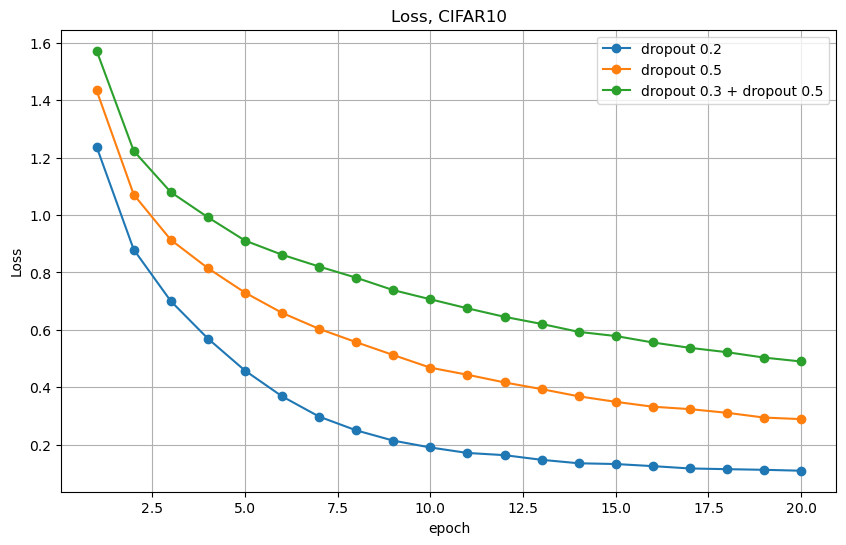

In [239]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), train_1_9, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), train_1_10, marker='o')
l3, = plt.plot(range(1, num_epochs + 1), train_1_11, marker='o')
plt.title('Loss, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2, l3], labels = ['dropout 0.2', 'dropout 0.5', 'dropout 0.3 + dropout 0.5'])
plt.grid(True)
plt.show()

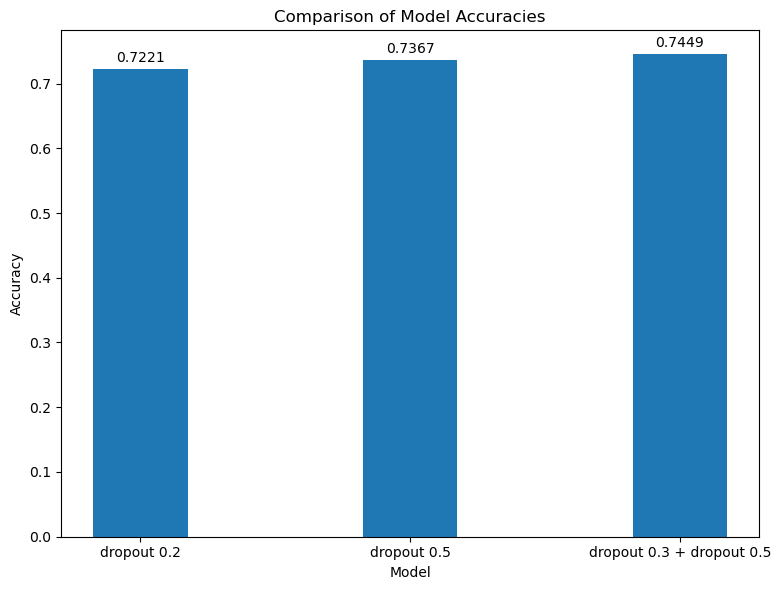

In [241]:
model_names = ['dropout 0.2', 'dropout 0.5', 'dropout 0.3 + dropout 0.5']
x = np.arange(len(model_names))
data = accuracy_list[8:11]
width = 0.35
fig, ax = plt.subplots(figsize = (8, 6))
rects1 = ax.bar(x, data, width, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Comparison of Model Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
autolabel(rects1)
fig.tight_layout()
plt.show()

Результаты соответствуют ожиданиям: с увеличением p модель обучается хуже, при этом на инференсе результаты лучше.   
Можно пробовать увеличивать дропаут и использовать сочетания разных р для улучшения качества модели на тестовой выборке

## 5. Полносвязные слои

### Полносвязный слой с малым количеством нейронов

In [176]:
class SimpleCNNVariant12(nn.Module):
    def __init__(self):
        super(SimpleCNNVariant12, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(64 * 8 * 8, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(x))
        x = self.fc(x)
        return x

In [177]:
model_cifar10_12 = SimpleCNNVariant12()
model_cifar10_12.to(device)
train_1_12 = train_model(model_cifar10_12, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.5006, Точность: 0.4846
Эпоха [2/20], Потери: 1.1676, Точность: 0.5933
Эпоха [3/20], Потери: 1.0452, Точность: 0.6374
Эпоха [4/20], Потери: 0.9666, Точность: 0.6630
Эпоха [5/20], Потери: 0.9194, Точность: 0.6798
Эпоха [6/20], Потери: 0.8816, Точность: 0.6931
Эпоха [7/20], Потери: 0.8463, Точность: 0.7052
Эпоха [8/20], Потери: 0.8195, Точность: 0.7160
Эпоха [9/20], Потери: 0.8018, Точность: 0.7207
Эпоха [10/20], Потери: 0.7815, Точность: 0.7297
Эпоха [11/20], Потери: 0.7552, Точность: 0.7372
Эпоха [12/20], Потери: 0.7458, Точность: 0.7406
Эпоха [13/20], Потери: 0.7319, Точность: 0.7450
Эпоха [14/20], Потери: 0.7182, Точность: 0.7481
Эпоха [15/20], Потери: 0.7075, Точность: 0.7512
Эпоха [16/20], Потери: 0.6957, Точность: 0.7556
Эпоха [17/20], Потери: 0.6847, Точность: 0.7596
Эпоха [18/20], Потери: 0.6811, Точность: 0.7625
Эпоха [19/20], Потери: 0.6652, Точность: 0.7673
Эпоха [20/20], Потери: 0.6653, Точность: 0.7679
Обучение завершено.


In [178]:
accuracy_1_12 = predict_model(model_cifar10_12, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_12)

### Последовательное применение нескольких полносвязных слоев (по сути, базовый класс SimpleCNN)

In [247]:
model_cifar10_13 = SimpleCNN()
model_cifar10_13.to(device)
train_1_13 = train_model(model_cifar10_13, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 1.4160, Точность: 0.4946
Эпоха [2/20], Потери: 1.0676, Точность: 0.6216
Эпоха [3/20], Потери: 0.9283, Точность: 0.6721
Эпоха [4/20], Потери: 0.8328, Точность: 0.7082
Эпоха [5/20], Потери: 0.7540, Точность: 0.7328
Эпоха [6/20], Потери: 0.6966, Точность: 0.7528
Эпоха [7/20], Потери: 0.6354, Точность: 0.7725
Эпоха [8/20], Потери: 0.5946, Точность: 0.7884
Эпоха [9/20], Потери: 0.5492, Точность: 0.8033
Эпоха [10/20], Потери: 0.5023, Точность: 0.8205
Эпоха [11/20], Потери: 0.4738, Точность: 0.8287
Эпоха [12/20], Потери: 0.4486, Точность: 0.8395
Эпоха [13/20], Потери: 0.4176, Точность: 0.8471
Эпоха [14/20], Потери: 0.3977, Точность: 0.8559
Эпоха [15/20], Потери: 0.3762, Точность: 0.8643
Эпоха [16/20], Потери: 0.3539, Точность: 0.8699
Эпоха [17/20], Потери: 0.3408, Точность: 0.8760
Эпоха [18/20], Потери: 0.3269, Точность: 0.8805
Эпоха [19/20], Потери: 0.3115, Точность: 0.8866
Эпоха [20/20], Потери: 0.3033, Точность: 0.8889
Обучение завершено.


In [248]:
accuracy_1_13 = predict_model(model_cifar10_13, cifar10_testloader, device)[2]
accuracy_list.append(accuracy_1_13)

### Определение правильного направления оптимизации

C:\Users\User\AppData\Local\Temp\ipykernel_14872\1764269292.py:7: UserWarning: Mismatched number of handles and labels: len(handles) = 3 len(labels) = 2
  plt.legend(handles = [l1,l2, l3], labels = ['1 layer', '2 layers'])


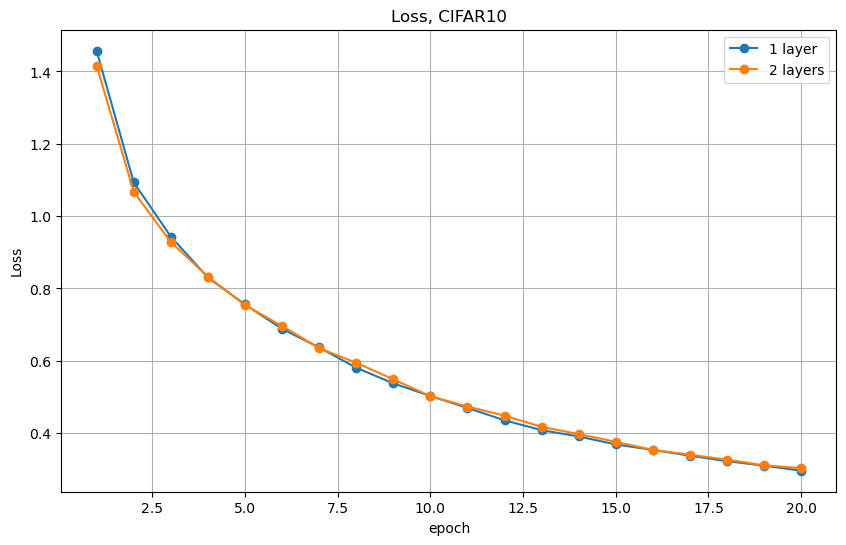

In [249]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), train_1_12, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), train_1_13, marker='o')
plt.title('Loss, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2, l3], labels = ['1 layer', '2 layers'])
plt.grid(True)
plt.show()

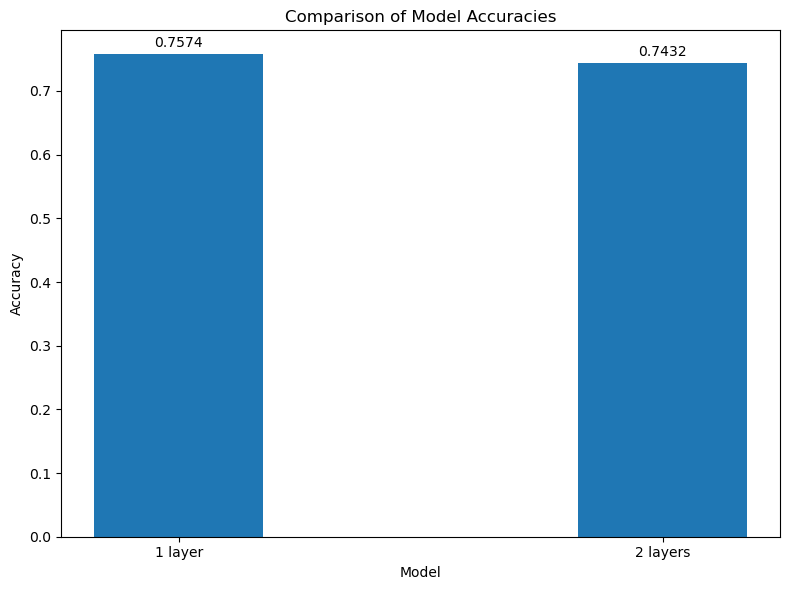

In [254]:
model_names = ['1 layer', '2 layers']
x = np.arange(len(model_names))
data = accuracy_list[11:13]
width = 0.35
fig, ax = plt.subplots(figsize = (8, 6))
rects1 = ax.bar(x, data, width, label='Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Comparison of Model Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
autolabel(rects1)
fig.tight_layout()
plt.show()

На этапе обучения разницы практически нет, в то время как на инференсе более простая модель показала лучшие результаты

# Раздел 4: Анализ гиперпараметров и оптимизация с использованием нестандартных методов (CIFAR)

## 1. Learning rate

### Использование Cyclic Learning Rate:

In [263]:
def train_cyclic_lr(model, train_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            running_loss += loss.item()
            if (i + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}')
                losses.append(running_loss / 100)
                running_loss = 0.0
    return losses

In [271]:
num_epochs = 20
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

In [273]:
model_cyclic_lr = SimpleCNN()
optimizer_cyclic_lr = optim.SGD(model_cyclic_lr.parameters(), lr=0.001, momentum=0.9)
scheduler_cyclic_lr = CyclicLR(optimizer_cyclic_lr, base_lr=0.001, max_lr=0.01, step_size_up=5 * len(cifar10_trainloader))
losses_cyclic_lr = train_cyclic_lr(model_cyclic_lr, cifar10_trainloader, criterion, optimizer_cyclic_lr, scheduler_cyclic_lr, num_epochs, device)

Epoch [1/20], Step [100/391], Loss: 1.9731, LR: 0.001460
Epoch [1/20], Step [200/391], Loss: 1.6229, LR: 0.001921
Epoch [1/20], Step [300/391], Loss: 1.4603, LR: 0.002381
Epoch [2/20], Step [100/391], Loss: 1.2638, LR: 0.003260
Epoch [2/20], Step [200/391], Loss: 1.2144, LR: 0.003721
Epoch [2/20], Step [300/391], Loss: 1.1620, LR: 0.004181
Epoch [3/20], Step [100/391], Loss: 1.0334, LR: 0.005060
Epoch [3/20], Step [200/391], Loss: 1.0213, LR: 0.005521
Epoch [3/20], Step [300/391], Loss: 1.0009, LR: 0.005981
Epoch [4/20], Step [100/391], Loss: 0.9087, LR: 0.006860
Epoch [4/20], Step [200/391], Loss: 0.8954, LR: 0.007321
Epoch [4/20], Step [300/391], Loss: 0.9235, LR: 0.007781
Epoch [5/20], Step [100/391], Loss: 0.8291, LR: 0.008660
Epoch [5/20], Step [200/391], Loss: 0.8347, LR: 0.009121
Epoch [5/20], Step [300/391], Loss: 0.8443, LR: 0.009581
Epoch [6/20], Step [100/391], Loss: 0.7473, LR: 0.009540
Epoch [6/20], Step [200/391], Loss: 0.7413, LR: 0.009079
Epoch [6/20], Step [300/391], L

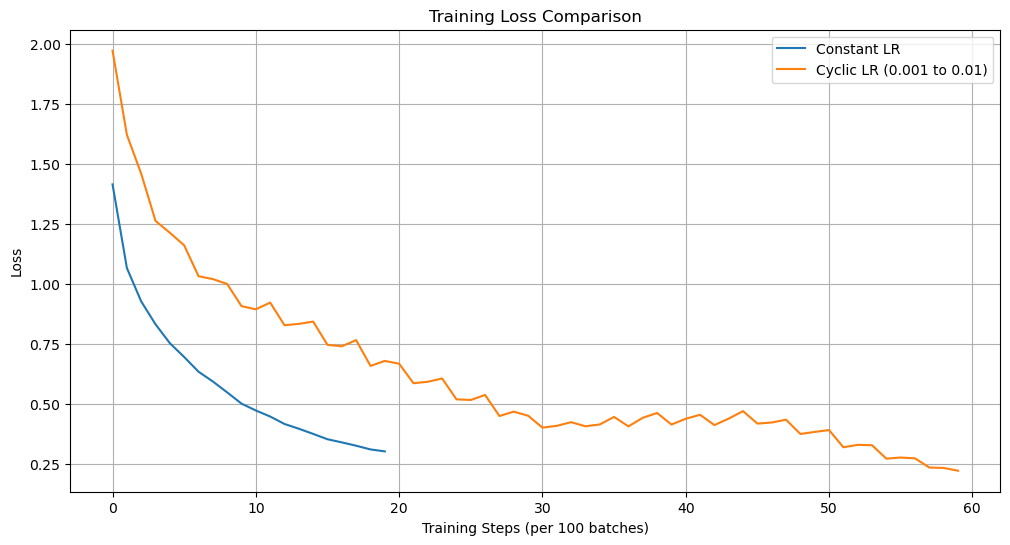

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_1_13)), train_1_13, label='Constant LR')
plt.plot(range(len(losses_cyclic_lr)), losses_cyclic_lr, label='Cyclic LR (0.001 to 0.01)')
plt.xlabel('Training Steps (per 100 batches)')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [284]:
accuracy_cyclic = predict_model(model_cyclic_lr, cifar10_testloader, device)[2]
print (f'accuracy на изначальной модели: {accuracy_1_13}/n accuracy на модели с цикличным lr: {accuracy_cyclic}')

accuracy на изначальной модели: 0.7358/n accuracy на модели с цикличным lr: 0.7601


Действительно, данный метод улучшил результаты на тесте, подняв accuracy на 0.025

## 2. Batch size

### Динамическое изменение Batch Size

In [293]:
def train_model_for_batches(model, train_dataset, device, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    initial_batch_size = 32
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        if epoch % 3 == 0:
           current_batch_size = initial_batch_size * (epoch // 3 + 1)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=current_batch_size,
                                          shuffle=True, num_workers=2)
        for batch_features, batch_target in train_loader:
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device).long()
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += batch_target.size(0)
            correct_predictions += (predicted == batch_target).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_samples
        epoch_losses.append(epoch_loss)
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}, Точность: {epoch_accuracy:.4f}')
    print('Обучение завершено.')
    return epoch_losses

In [301]:
num_epochs = 20
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dynamic_bs = SimpleCNN()
model_dynamic_bs.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [303]:
epochs_dynamic_bs = train_model_for_batches(model_dynamic_bs, cifar10_train,device, lr , num_epochs)

Эпоха [1/20], Потери: 1.4415, Точность: 0.4840
Эпоха [2/20], Потери: 1.1023, Точность: 0.6111
Эпоха [3/20], Потери: 0.9658, Точность: 0.6623
Эпоха [4/20], Потери: 0.7857, Точность: 0.7255
Эпоха [5/20], Потери: 0.7282, Точность: 0.7444
Эпоха [6/20], Потери: 0.6823, Точность: 0.7603
Эпоха [7/20], Потери: 0.5898, Точность: 0.7920
Эпоха [8/20], Потери: 0.5502, Точность: 0.8048
Эпоха [9/20], Потери: 0.5231, Точность: 0.8111
Эпоха [10/20], Потери: 0.4580, Точность: 0.8349
Эпоха [11/20], Потери: 0.4278, Точность: 0.8449
Эпоха [12/20], Потери: 0.4064, Точность: 0.8523
Эпоха [13/20], Потери: 0.3684, Точность: 0.8663
Эпоха [14/20], Потери: 0.3433, Точность: 0.8758
Эпоха [15/20], Потери: 0.3293, Точность: 0.8812
Эпоха [16/20], Потери: 0.3035, Точность: 0.8897
Эпоха [17/20], Потери: 0.2924, Точность: 0.8919
Эпоха [18/20], Потери: 0.2784, Точность: 0.8963
Эпоха [19/20], Потери: 0.2545, Точность: 0.9070
Эпоха [20/20], Потери: 0.2487, Точность: 0.9065
Обучение завершено.


### Gradient Accumulation

In [306]:
def train_model_with_gradient_accumulation(model, train_loader, device, learning_rate, num_epochs, accumulation_steps):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        optimizer.zero_grad()
        for i, (batch_features, batch_target) in enumerate(train_loader):
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device).long()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)
            loss = loss / accumulation_steps
            loss.backward()
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
            running_loss += loss.item() * batch_features.size(0) * accumulation_steps
            _, predicted = torch.max(outputs, 1)
            total_samples += batch_target.size(0)
            correct_predictions += (predicted == batch_target).sum().item()
        if (len(train_loader) % accumulation_steps) != 0:
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_samples
        epoch_losses.append(epoch_loss)
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}, Точность: {epoch_accuracy:.4f}')
    print('Обучение завершено.')
    return epoch_losses

In [311]:
model_g_acc = SimpleCNN().to(device) # Переместите модель на устройство
accumulation_steps = 4
epochs_g_acc = train_model_with_gradient_accumulation(model_g_acc, cifar10_trainloader, device, lr, num_epochs, accumulation_steps)

Эпоха [1/20], Потери: 1.5262, Точность: 0.4514
Эпоха [2/20], Потери: 1.1399, Точность: 0.5947
Эпоха [3/20], Потери: 0.9763, Точность: 0.6553
Эпоха [4/20], Потери: 0.8633, Точность: 0.6972
Эпоха [5/20], Потери: 0.7769, Точность: 0.7255
Эпоха [6/20], Потери: 0.7066, Точность: 0.7499
Эпоха [7/20], Потери: 0.6437, Точность: 0.7714
Эпоха [8/20], Потери: 0.5917, Точность: 0.7918
Эпоха [9/20], Потери: 0.5418, Точность: 0.8060
Эпоха [10/20], Потери: 0.4981, Точность: 0.8206
Эпоха [11/20], Потери: 0.4634, Точность: 0.8314
Эпоха [12/20], Потери: 0.4219, Точность: 0.8461
Эпоха [13/20], Потери: 0.3931, Точность: 0.8562
Эпоха [14/20], Потери: 0.3688, Точность: 0.8649
Эпоха [15/20], Потери: 0.3503, Точность: 0.8721
Эпоха [16/20], Потери: 0.3299, Точность: 0.8800
Эпоха [17/20], Потери: 0.3160, Точность: 0.8847
Эпоха [18/20], Потери: 0.2896, Точность: 0.8938
Эпоха [19/20], Потери: 0.2791, Точность: 0.8973
Эпоха [20/20], Потери: 0.2733, Точность: 0.9000
Обучение завершено.


### Сравнение

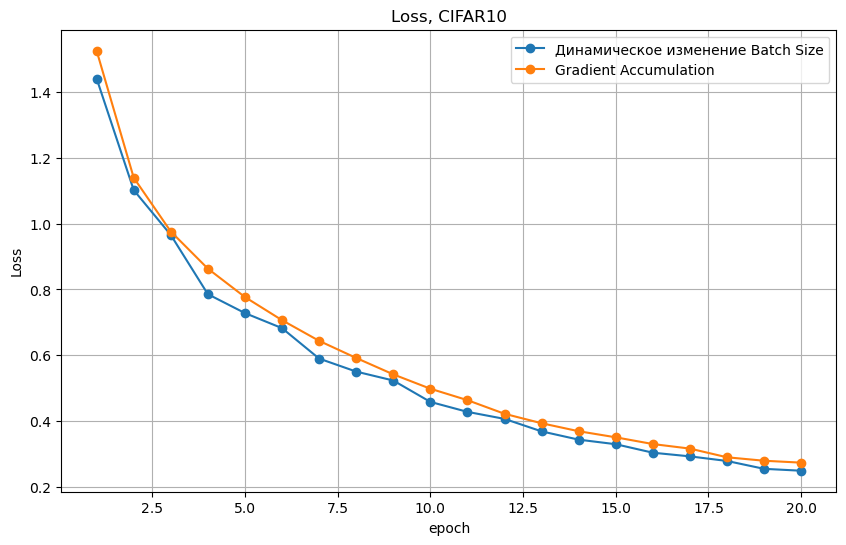

In [319]:
plt.figure(figsize=(10, 6))
l1, = plt.plot(range(1, num_epochs + 1), epochs_dynamic_bs, marker='o')
l2, = plt.plot(range(1, num_epochs + 1), epochs_g_acc, marker='o')
plt.title('Loss, CIFAR10')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(handles = [l1,l2], labels = ['Динамическое изменение Batch Size', 'Gradient Accumulation'])
plt.grid(True)
plt.show()

## 3. Количество фильтров и слоев

### Progressive Layer Growth

In [335]:
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 10) # Изменен размер FC слоя

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 32 * 16 * 16)
        x = self.fc1(x)
        return x

# CNN с одним дополнительным сверточным слоем
class GrownCNN_Conv2(nn.Module):
    def __init__(self):
        super(GrownCNN_Conv2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 10) # Изменен размер FC слоя

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        return x

# CNN с двумя дополнительными сверточными слоями и полносвязными слоями
class GrownCNN_Full(nn.Module):
    def __init__(self):
        super(GrownCNN_Full, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(self.batch_norm(torch.relu(self.conv2(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [337]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100 * correct / total
    return epoch_loss, epoch_accuracy
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [339]:
def progressive_layer_growth_training(train_loader, test_loader, device, learning_rate, num_epochs_stage1, num_epochs_stage2, num_epochs_stage3):
    criterion = nn.CrossEntropyLoss()

    # Стадия 1: Обучение базовой CNN
    print("Стадия 1: Обучение базовой CNN...")
    model_stage1 = BaseCNN().to(device)
    optimizer_stage1 = optim.Adam(model_stage1.parameters(), lr=learning_rate)
    for epoch in range(num_epochs_stage1):
        loss, accuracy = train_model(model_stage1, train_loader, optimizer_stage1, criterion, device)
        print(f"Эпоха [{epoch+1}/{num_epochs_stage1}], Потери: {loss:.4f}, Точность на обучении: {accuracy:.2f}%")
    test_accuracy_stage1 = evaluate_model(model_stage1, test_loader, device)
    print(f"Точность на тестовом наборе (Стадия 1): {test_accuracy_stage1:.2f}%")

    # Стадия 2: Добавление сверточного слоя и обучение
    print("\nСтадия 2: Добавление сверточного слоя и обучение...")
    model_stage2 = GrownCNN_Conv2().to(device)
    # Инициализация весов первой части модели весами из первой стадии (опционально)
    model_stage2.conv1.weight.data = model_stage1.conv1.weight.data
    model_stage2.conv1.bias.data = model_stage1.conv1.bias.data
    model_stage2.fc1.weight.data = model_stage1.fc1.weight.data
    model_stage2.fc1.bias.data = model_stage1.fc1.bias.data

    optimizer_stage2 = optim.Adam(model_stage2.parameters(), lr=learning_rate)
    for epoch in range(num_epochs_stage2):
        loss, accuracy = train_model(model_stage2, train_loader, optimizer_stage2, criterion, device)
        print(f"Эпоха [{epoch+1}/{num_epochs_stage2}], Потери: {loss:.4f}, Точность на обучении: {accuracy:.2f}%")
    test_accuracy_stage2 = evaluate_model(model_stage2, test_loader, device)
    print(f"Точность на тестовом наборе (Стадия 2): {test_accuracy_stage2:.2f}%")

    # Стадия 3: Добавление полносвязных слоев и обучение (переход к SimpleCNN)
    print("\nСтадия 3: Добавление полносвязных слоев и обучение...")
    model_stage3 = GrownCNN_Full().to(device)
    # Инициализация весов первой части модели весами из второй стадии (опционально)
    model_stage3.conv1.weight.data = model_stage2.conv1.weight.data
    model_stage3.conv1.bias.data = model_stage2.conv1.bias.data
    model_stage3.conv2.weight.data = model_stage2.conv2.weight.data
    model_stage3.conv2.bias.data = model_stage2.conv2.bias.data

    optimizer_stage3 = optim.Adam(model_stage3.parameters(), lr=learning_rate)
    for epoch in range(num_epochs_stage3):
        loss, accuracy = train_model(model_stage3, train_loader, optimizer_stage3, criterion, device)
        print(f"Эпоха [{epoch+1}/{num_epochs_stage3}], Потери: {loss:.4f}, Точность на обучении: {accuracy:.2f}%")
    test_accuracy_stage3 = evaluate_model(model_stage3, test_loader, device)
    print(f"Точность на тестовом наборе (Стадия 3): {test_accuracy_stage3:.2f}%")

In [341]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
num_epochs_stage1 = 5
num_epochs_stage2 = 5
num_epochs_stage3 = 10

In [343]:
progressive_layer_growth_training(cifar10_trainloader, cifar10_testloader, device, learning_rate, num_epochs_stage1, num_epochs_stage2, num_epochs_stage3)

Стадия 1: Обучение базовой CNN...
Эпоха [1/5], Потери: 1.4483, Точность на обучении: 49.18%
Эпоха [2/5], Потери: 1.1670, Точность на обучении: 59.67%
Эпоха [3/5], Потери: 1.0587, Точность на обучении: 63.46%
Эпоха [4/5], Потери: 0.9820, Точность на обучении: 66.34%
Эпоха [5/5], Потери: 0.9280, Точность на обучении: 68.21%
Точность на тестовом наборе (Стадия 1): 64.18%

Стадия 2: Добавление сверточного слоя и обучение...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x4096 and 8192x10)

### Random Filter Pruning

In [347]:
def train_model(model, train_loader, device, learning_rate, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}, Точность на обучении: {epoch_accuracy:.2f}%')
    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Точность на тестовом наборе: {100 * correct / total:.2f}%')

In [349]:
def prune_filters(model, threshold=0.1):
    for name, param in model.named_parameters():
        if "weight" in name:
            param.data = F.dropout(param.data, p=threshold, training=True) # Важно установить training=True

In [353]:
num_epochs = 20
pruning_threshold = 0.2

# 1. Обучение обычной модели
print("Обучение обычной модели...")
model_original = SimpleCNN().to(device)
train_model(model_original, cifar10_trainloader, device, lr, num_epochs)
evaluate_model(model_original, cifar10_testloader, device)

# 2. Создание копии модели и применение "отсечения"
print("\nСоздание копии модели и применение случайного 'отсечения' весов...")
model_pruned = SimpleCNN().to(device)
model_pruned.load_state_dict(model_original.state_dict()) # Загружаем веса обученной модели
prune_filters(model_pruned, threshold=pruning_threshold)

# 3. Обучение "отсеченной" модели (можно продолжить обучение или обучать с нуля)
print(f"\nОбучение модели с случайным 'отсечением' весов (threshold={pruning_threshold})...")
train_model(model_pruned, cifar10_trainloader, device, lr, num_epochs)
evaluate_model(model_pruned, cifar10_testloader, device)

Обучение обычной модели...
Эпоха [1/20], Потери: 1.4181, Точность на обучении: 49.35%
Эпоха [2/20], Потери: 1.0614, Точность на обучении: 62.45%
Эпоха [3/20], Потери: 0.9113, Точность на обучении: 67.74%
Эпоха [4/20], Потери: 0.8087, Точность на обучении: 71.36%
Эпоха [5/20], Потери: 0.7305, Точность на обучении: 74.28%
Эпоха [6/20], Потери: 0.6678, Точность на обучении: 76.40%
Эпоха [7/20], Потери: 0.6082, Точность на обучении: 78.35%
Эпоха [8/20], Потери: 0.5598, Точность на обучении: 80.01%
Эпоха [9/20], Потери: 0.5190, Точность на обучении: 81.54%
Эпоха [10/20], Потери: 0.4848, Точность на обучении: 82.59%
Эпоха [11/20], Потери: 0.4504, Точность на обучении: 83.80%
Эпоха [12/20], Потери: 0.4209, Точность на обучении: 84.85%
Эпоха [13/20], Потери: 0.4034, Точность на обучении: 85.45%
Эпоха [14/20], Потери: 0.3790, Точность на обучении: 86.10%
Эпоха [15/20], Потери: 0.3519, Точность на обучении: 87.30%
Эпоха [16/20], Потери: 0.3349, Точность на обучении: 87.75%
Эпоха [17/20], Потери:

# Раздел 5: Анализ различных метрик производительности (CIFAR)

## 1. Вычисление и сравнение метрик

In [385]:
def train_model(model, train_loader, device, learning_rate, num_epochs, num_classes=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    epoch_losses = []
    epoch_accuracies = []
    epoch_precisions = []
    epoch_recalls = []
    epoch_f1s = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        all_targets = []
        all_predictions = []
        for batch_features, batch_target in train_loader:
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device).long()
            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_features.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += batch_target.size(0)
            correct_predictions += (predicted == batch_target).sum().item()
            all_targets.extend(batch_target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_samples
        epoch_losses.append(epoch_loss)
        epoch_accuracies.append(epoch_accuracy)

        epoch_precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
        epoch_recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
        epoch_f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)
        epoch_precisions.append(epoch_precision)
        epoch_recalls.append(epoch_recall)
        epoch_f1s.append(epoch_f1)

        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {epoch_loss:.4f}, Точность: {epoch_accuracy:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1: {epoch_f1:.4f}')

    print('Обучение завершено.')
    return epoch_losses, epoch_accuracies, epoch_precisions, epoch_recalls, epoch_f1s

In [362]:
def evaluate_model(model, test_loader, device, num_classes=10):
    model.eval()
    all_targets = []
    all_predictions = []
    all_probabilities = []
    with torch.no_grad():
        for batch_features, batch_target in test_loader:
            batch_features = batch_features.to(device)
            batch_target = batch_target.to(device).long()
            outputs = model(batch_features)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_targets.extend(batch_target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    precision = precision_score(all_targets, all_predictions, average='weighted')
    recall = recall_score(all_targets, all_predictions, average='weighted')
    f1 = f1_score(all_targets, all_predictions, average='weighted')

    roc_auc = []
    for i in range(num_classes):
        binary_targets = (np.array(all_targets) == i).astype(int)
        binary_probabilities = np.array(all_probabilities)[:, i]
        try:
            roc_auc.append(roc_auc_score(binary_targets, binary_probabilities))
        except ValueError:
            roc_auc.append(np.nan)
    mean_roc_auc = np.nanmean(roc_auc)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
    print(f'Точность на тестовом наборе: {accuracy:.4f}')
    print(f'Precision на тестовом наборе: {precision:.4f}')
    print(f'Recall на тестовом наборе: {recall:.4f}')
    print(f'F1-score на тестовом наборе: {f1:.4f}')
    print(f'Mean ROC AUC на тестовом наборе: {mean_roc_auc:.4f}')

    return accuracy, precision, recall, f1, mean_roc_auc, all_targets, all_predictions, all_probabilities

In [366]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
num_epochs = 20
lr = 0.001
model_metrics = SimpleCNN().to(device)

Используемое устройство: cuda


In [387]:
metrics_per_epoch = train_model(model_metrics, cifar10_trainloader, device, lr, num_epochs)

Эпоха [1/20], Потери: 0.4372, Точность: 0.8444, Precision: 0.8439, Recall: 0.8444, F1: 0.8441
Эпоха [2/20], Потери: 0.4036, Точность: 0.8535, Precision: 0.8531, Recall: 0.8535, F1: 0.8533
Эпоха [3/20], Потери: 0.3788, Точность: 0.8617, Precision: 0.8614, Recall: 0.8617, F1: 0.8616
Эпоха [4/20], Потери: 0.3548, Точность: 0.8713, Precision: 0.8711, Recall: 0.8713, F1: 0.8711
Эпоха [5/20], Потери: 0.3418, Точность: 0.8754, Precision: 0.8753, Recall: 0.8754, F1: 0.8753
Эпоха [6/20], Потери: 0.3224, Точность: 0.8812, Precision: 0.8811, Recall: 0.8812, F1: 0.8811
Эпоха [7/20], Потери: 0.3056, Точность: 0.8885, Precision: 0.8883, Recall: 0.8885, F1: 0.8884
Эпоха [8/20], Потери: 0.2999, Точность: 0.8913, Precision: 0.8913, Recall: 0.8913, F1: 0.8913
Эпоха [9/20], Потери: 0.2874, Точность: 0.8944, Precision: 0.8944, Recall: 0.8944, F1: 0.8943
Эпоха [10/20], Потери: 0.2751, Точность: 0.8990, Precision: 0.8990, Recall: 0.8990, F1: 0.8990
Эпоха [11/20], Потери: 0.2713, Точность: 0.9007, Precision:

In [391]:
evaluate_model(model_metrics, cifar10_testloader, device)

Точность на тестовом наборе: 0.7378
Precision на тестовом наборе: 0.7380
Recall на тестовом наборе: 0.7378
F1-score на тестовом наборе: 0.7370
Mean ROC AUC на тестовом наборе: 0.9608


(0.7378,
 0.7380447582941405,
 0.7378,
 0.7369987180477802,
 0.9607692999999999,
 [3,
  8,
  2,
  4,
  6,
  8,
  6,
  2,
  3,
  8,
  5,
  8,
  1,
  8,
  4,
  5,
  7,
  7,
  4,
  3,
  2,
  5,
  6,
  9,
  6,
  4,
  3,
  2,
  0,
  1,
  1,
  4,
  8,
  2,
  3,
  7,
  9,
  5,
  4,
  8,
  1,
  0,
  5,
  8,
  2,
  8,
  3,
  5,
  1,
  4,
  0,
  8,
  2,
  6,
  2,
  1,
  4,
  8,
  6,
  3,
  4,
  0,
  7,
  4,
  3,
  5,
  1,
  8,
  6,
  3,
  1,
  6,
  1,
  8,
  7,
  7,
  5,
  4,
  2,
  1,
  8,
  1,
  9,
  9,
  9,
  9,
  3,
  4,
  0,
  6,
  8,
  0,
  4,
  7,
  7,
  3,
  4,
  1,
  6,
  2,
  0,
  5,
  4,
  8,
  6,
  2,
  1,
  8,
  3,
  9,
  1,
  9,
  2,
  7,
  3,
  1,
  1,
  8,
  9,
  9,
  2,
  8,
  2,
  3,
  5,
  4,
  7,
  8,
  9,
  1,
  1,
  5,
  3,
  2,
  6,
  5,
  9,
  2,
  0,
  7,
  0,
  0,
  6,
  4,
  5,
  1,
  7,
  2,
  7,
  3,
  5,
  9,
  6,
  8,
  6,
  9,
  9,
  9,
  0,
  8,
  0,
  9,
  3,
  1,
  5,
  2,
  9,
  8,
  5,
  9,
  8,
  7,
  1,
  2,
  8,
  8,
  3,
  2,
  5,
  1,
  4,
  5,
  5,
  9,

На трейне все метрики +- схожи, это говорит об отсутствии дисбаланса классов. На трейне все круто, но на тесте метрики около 0.74. В то же время, roc-auc 0.96 говорит, что модель практически идеально распознает классы.